## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/sw_contest"

Mounted at /content/drive
/content/drive/MyDrive/sw_contest


In [2]:
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 6.9 MB/s eta 0:00:00


In [3]:

!pip install segmentation_models_pytorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00


In [4]:
!pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os

import cv2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Dice
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning as L
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from lightning.pytorch.loggers import WandbLogger

In [6]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [7]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')


# folder1_path = '/content/gdrive/MyDrive/sw_contest'
# folder2_path = '/content/gdrive/MyDrive/sw_contest/train_img'
# # folder3_path = '/content/gdrive/Othercomputers/내 노트북/test_img'

In [8]:
!pip install --upgrade opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


## Utils

In [9]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#Validation augmentation

In [ ]:
train_df = pd.read_csv("./train.csv")
train_df['mask_rle'][0]

'9576 7 10590 17 11614 17 12638 17 13662 17 14686 17 15710 17 16734 17 17716 100 18740 100 19764 100 20788 100 21812 100 22836 100 23860 100 24884 100 25908 100 26932 100 27956 100 28980 100 30004 100 31028 100 32052 100 33076 100 34100 100 35124 100 36148 100 37172 100 38196 100 39220 100 40244 100 41268 100 42292 100 43317 99 44341 99 45365 99 46389 99 47413 99 48437 99 49461 99 50485 99 51509 99 52533 99 53557 99 54581 99 55605 99 56629 99 57653 99 58677 99 59701 99 60722 1 60725 99 61749 99 62773 99 63797 99 64821 99 65845 99 66481 45 66869 99 67505 55 67893 99 68529 55 68917 99 69553 55 69941 99 70577 55 70965 99 71601 55 71989 99 72625 55 73013 99 73649 55 74037 99 74673 55 75061 99 75697 55 76085 99 76721 55 77109 99 77745 55 78133 99 78769 55 79157 21 79793 55 80817 55 81251 1 81841 55 82865 55 83889 55 84913 55 85937 55 86961 55 87985 55 89009 55 90033 55 91057 55 92081 55 93105 55 94129 55 95153 55 96177 57 97201 57 98225 57 99249 57 100273 57 101297 57 102321 57 103345 57 10

In [ ]:
train_df = pd.read_csv("./train.csv")
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0, shuffle=True)
print(len(train_df))

4998


In [ ]:
print(len(train_df))
print(len(val_df))

4998
2142


In [ ]:
def crop_img(img, img_size=256):
    img_list = []

    y_cnt = 0
    while True:
        start_y = y_cnt * img_size
        end_y = (y_cnt + 1) * img_size

        if end_y > 1024:
            break

        x_cnt = 0
        while True:
            start_x = x_cnt * img_size
            end_x = (x_cnt + 1) * img_size

            if end_x > 1024:
                break

            temp_img = img[start_x:end_x, start_y:end_y, :]
            x_cnt += 1
            img_list.append(temp_img)

        y_cnt += 1

    return img_list

In [ ]:
new_data_list = []
for idx, row in val_df.iterrows():
    img_name = row["img_path"].split("/")[-1]
    img_path = os.path.join("./train_img", img_name)
    mask_path = os.path.join("./train_mask", img_name)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    images = crop_img(img)
    masks = crop_img(mask)

    for idx, (img, mask) in enumerate(zip(images, masks)):
        new_img_name = img_name[:-4] + "_" + str(idx).zfill(2) + ".png"


        new_data_list.append({"img_id": new_img_name[:-4]})


        cv2.imwrite(os.path.join("./train_img3", new_img_name), img)
        cv2.imwrite(os.path.join("./train_mask3", new_img_name), mask)


In [ ]:
#./test_img/TEST_00008.png
new_data_path = []

for filename in os.listdir('./train_img3'):
  new_data_path.append({'img_path': "./train_img3/" + filename})

print(new_data_path[0])


{'img_path': './train_img3/TRAIN_4972_00.png'}


In [ ]:
new_val_df = pd.DataFrame(new_data_list)


In [ ]:
new_val_df2 = pd.DataFrame(new_data_path)


In [ ]:
val = pd.concat([new_val_df, new_val_df2], axis=1)
print(val)

              img_id                        img_path
0      TRAIN_4972_00  ./train_img3/TRAIN_4972_00.png
1      TRAIN_4972_01  ./train_img3/TRAIN_4972_01.png
2      TRAIN_4972_02  ./train_img3/TRAIN_4972_02.png
3      TRAIN_4972_03  ./train_img3/TRAIN_4972_03.png
4      TRAIN_4972_04  ./train_img3/TRAIN_4972_04.png
...              ...                             ...
34267  TRAIN_0552_11  ./train_img3/TRAIN_0552_11.png
34268  TRAIN_0552_12  ./train_img3/TRAIN_0552_12.png
34269  TRAIN_0552_13  ./train_img3/TRAIN_0552_13.png
34270  TRAIN_0552_14  ./train_img3/TRAIN_0552_14.png
34271  TRAIN_0552_15  ./train_img3/TRAIN_0552_15.png

[34272 rows x 2 columns]


In [ ]:
val.to_csv("./val.csv", index=False)

이미지 보기

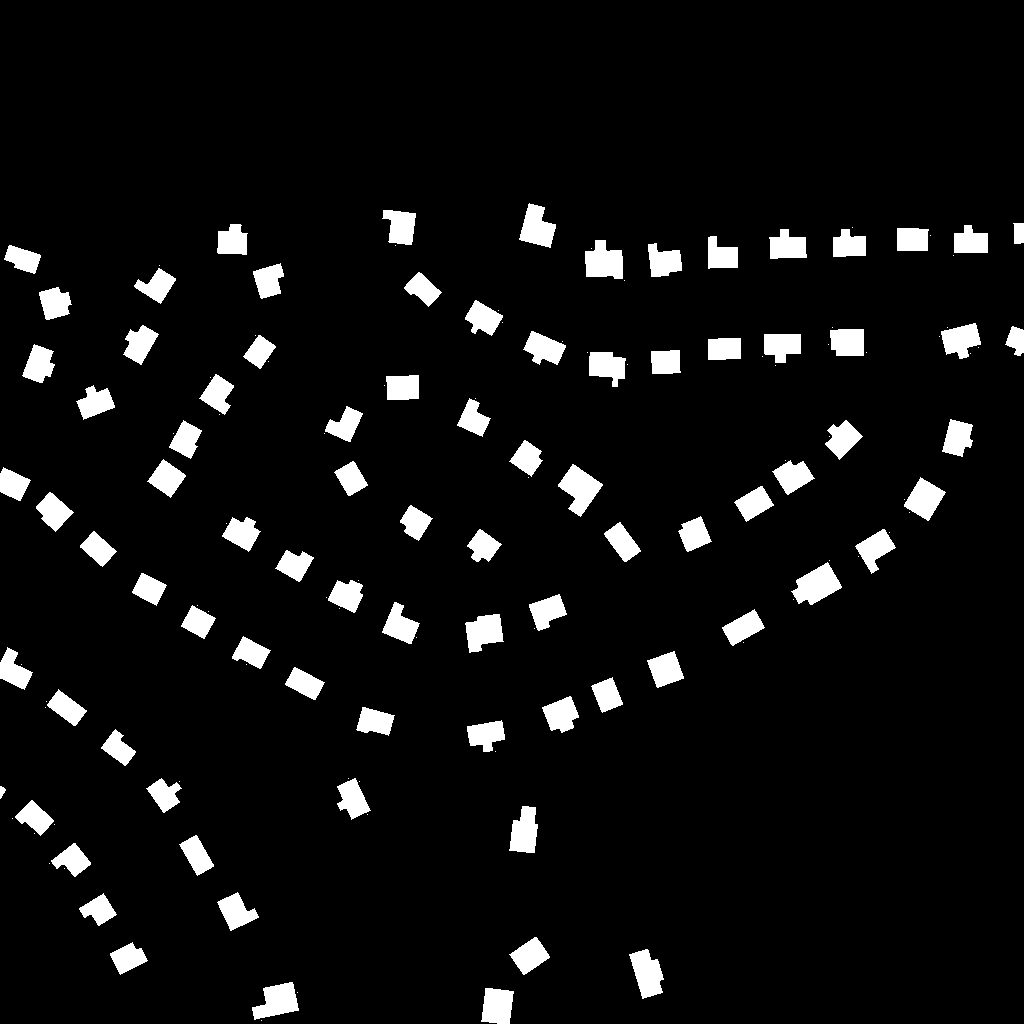

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
df = pd.read_csv("./train.csv")

image_path = df.iloc[1,1] # Replace with the path to the image file
image = cv2.imread(image_path)

# Example mask_rle (Replace with the actual mask_rle for TRAIN_0000)
mask_rle = df.iloc[1,2]

# Function to decode mask_rle into binary mask image
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Convert mask_rle to binary mask image
binary_mask_image = rle_decode(mask_rle, shape=(1024, 1024))

# Convert binary_mask_image to grayscale
gray_mask_image = binary_mask_image * 255

# Find contours in the binary mask image
contours, _ = cv2.findContours(binary_mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw each contour as a line on the original image
for contour in contours:
    cv2.drawContours(image, [contour], -1, (0, 0, 255), 1)  # Red color for the contours

# Display the grayscale mask image using cv2_imshow
cv2_imshow(gray_mask_image)


## Custom Dataset

origin

In [10]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=False, val=False, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        self.val = val
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]

        if self.train:
            image = cv2.imread(os.path.join("./train_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join("./train_mask", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']


            return image, mask

        elif self.val:
            image = cv2.imread(os.path.join("./train_img3", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join("./train_mask3", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask

        elif self.infer:
            image = cv2.imread(os.path.join("./test_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image=image)['image']
            return image



one-hot

In [11]:
import torch

def one_hot_encode(label, num_classes):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a one-hot vector.
    # Arguments
        label: The 2D array segmentation image label
        num_classes: Number of classes in the segmentation task

    # Returns
        A 3D tensor with one-hot encoding where each pixel value
        is represented as a one-hot vector of length num_classes.
    """
    h, w = label.shape
    one_hot = torch.zeros((num_classes, h, w), dtype=torch.uint8)
    for class_idx in range(num_classes):
        one_hot[class_idx] = (label == class_idx).to(torch.uint8)

    return one_hot


class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=False, val=False, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        self.val = val
        self.infer = infer
        self.num_classes = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]

        if self.train:
            image = cv2.imread(os.path.join("./train_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join("./train_mask", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

                mask = one_hot_encode(mask, self.num_classes)

            return image, mask

        elif self.val:
            image = cv2.imread(os.path.join("./train_img3", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join("./train_mask3", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

                mask = one_hot_encode(mask, self.num_classes)

            return image, mask

        elif self.infer:
            image = cv2.imread(os.path.join("./test_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image=image)['image']

            return image



Gray scale

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=False, val=False, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        self.val = val
        self.infer = infer
        self.num_classes = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]

        if self.train:
            image = cv2.imread(os.path.join("./train_img", img_name + ".png"), cv2.IMREAD_GRAYSCALE)
            image = np.expand_dims(image, axis=-1)

            mask = cv2.imread(os.path.join("./train_mask", img_name + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = np.expand_dims(mask, axis=-1)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask

        elif self.val:
            image = cv2.imread(os.path.join("./train_img3", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join("./train_mask3", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask

        elif self.infer:
            image = cv2.imread(os.path.join("./test_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image=image)['image']

            return image


## Data Loader

one-hot encoding 추가

In [12]:
def train_transform():
        return A.Compose(
            [
                A.OneOf(
                    [
                        A.RandomBrightness(p=1),
                        A.RandomBrightnessContrast(p=1),
                        A.Emboss(p=1),
                        A.RandomShadow(p=1),
                        A.NoOp(),
                    ],
                    p=1,
                ),

                A.OneOf(
                    [
                        A.NoOp(),
                        A.HorizontalFlip(p=0.5),
                        A.ShiftScaleRotate(p=0.5),
                        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_REPLICATE),
                        A.RandomRotate90(p=1)
                    ],
                    p=1,
                ),
                A.OneOf(
                    [
                        A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
                        A.NoOp(),
                    ],
                    p=1,
                ),

                A.RandomCrop(224, 224),
                A.Normalize(),
                ToTensorV2(transpose_mask=False)
            ]
        )

def val_transform():
    return A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2(transpose_mask=True)
        ]
    )

def test_transform():
        return A.Compose(
            [
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )

train_transform = train_transform()
val_transform = val_transform()
test_transform = test_transform()



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  self.max_value = max_value
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  f"{self.__class__.__name__} has been deprecated. Please use CoarseDropout",


## Define Model

## Model Train

In [ ]:
# model 초기화
import segmentation_models_pytorch as smp

lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

num_classes = 2

# 전이 학습에 사용할 미리 학습된 DeepLabV3Plus 모델 가져오기
model = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=num_classes)

# 모델을 GPU로 이동
model.to(device)

# loss function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# training loop
for epoch in range(num_epochs):  # 30 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch+1)%10 == 0:
      torch.save(model.state_dict(), './songweights/v3plus2_' + str(epoch+1) + '.pth')


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 86.9MB/s]


NameError: ignored

In [ ]:
# # model 초기화
# model = DeepLabV3Plus(in_channels=3,num_classes=2).to(device)

# # loss function과 optimizer 정의
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # training loop
# for epoch in range(10):  # 10 에폭 동안 학습합니다.
#     model.train()
#     epoch_loss = 0
#     for images, masks in tqdm(dataloader):
#         images = images.float().to(device)
#         masks = masks.float().to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks.unsqueeze(1))
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

#train val

In [ ]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리

#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

#         return 1 - dice

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터셋 불러오기 및 전처리
train_dataset = SatelliteDataset(csv_file='./train.csv', transform=train_transform, train=True)
val_dataset = SatelliteDataset(csv_file='./val.csv', transform=val_transform, val=True)

# 전체 데이터를 학습용과 검증용으로 분리

# DataLoader 정의
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# 모델 초기화
import segmentation_models_pytorch as smp

lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
num_classes = 2

# 전이 학습에 사용할 미리 학습된 DeepLabV3Plus 모델 가져오기
model = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=num_classes)
#model = smp.UnetPlusPlus(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=num_classes)
#model = smp.Segformer(encoder_name="mit_b5", encoder_weights="imagenet", in_channels=3, classes=num_classes)
# 모델을 GPU로 이동
model.to(device)


#weight_init = torch.load("./JOweights/train_val_2_80.pth")
#model.load_state_dict(weight_init, strict=False)
# loss function과 optimizer 정의
#criterion = torch.nn.CrossEntropyLoss()
#criterion = DiceLoss()
criterion = smp.losses.DiceLoss(mode='binary')



#optimizer = torch.optim.Adam(model.parameters(), lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)

# training loop
for epoch in range(num_epochs):  # 30 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}')

    # learning rate scheduler 갱신
    scheduler.step()

    # 검증 데이터를 사용하여 모델 평가
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f'Validation Loss: {val_loss/len(val_dataloader)}')

    # 모델 저장
    if (epoch+1) % 2 == 0:
      torch.save(model.state_dict(), f'./JOweights/last_{epoch+1}.pth')


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 59.2MB/s]
100%|██████████| 112/112 [13:59<00:00,  7.49s/it]


Epoch 1, Loss: 0.2510352331612791


100%|██████████| 357/357 [35:32<00:00,  5.97s/it]


Validation Loss: 0.14481117595143678


100%|██████████| 112/112 [03:39<00:00,  1.96s/it]


Epoch 2, Loss: 0.09928896384579795


100%|██████████| 357/357 [02:42<00:00,  2.20it/s]


Validation Loss: 0.10047908156525855


100%|██████████| 112/112 [03:43<00:00,  1.99s/it]


Epoch 3, Loss: 0.0811186885195119


100%|██████████| 357/357 [02:42<00:00,  2.19it/s]


Validation Loss: 0.08673654751283448


100%|██████████| 112/112 [03:47<00:00,  2.03s/it]


Epoch 4, Loss: 0.0744335065994944


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.07985621173174776


100%|██████████| 112/112 [03:41<00:00,  1.98s/it]


Epoch 5, Loss: 0.0707621042217527


100%|██████████| 357/357 [02:42<00:00,  2.19it/s]


Validation Loss: 0.07577533264454006


100%|██████████| 112/112 [03:44<00:00,  2.00s/it]


Epoch 6, Loss: 0.06830341422132083


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.0731043800586412


100%|██████████| 112/112 [03:46<00:00,  2.02s/it]


Epoch 7, Loss: 0.06731013687593597


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.07129438050320837


100%|██████████| 112/112 [03:47<00:00,  2.03s/it]


Epoch 8, Loss: 0.0664108337036201


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06977056321643647


100%|██████████| 112/112 [03:46<00:00,  2.02s/it]


Epoch 9, Loss: 0.06560972120080676


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.06873288358292994


100%|██████████| 112/112 [03:45<00:00,  2.02s/it]


Epoch 10, Loss: 0.06522300413676671


100%|██████████| 357/357 [02:44<00:00,  2.18it/s]


Validation Loss: 0.06785599407361669


100%|██████████| 112/112 [03:49<00:00,  2.05s/it]


Epoch 11, Loss: 0.06416955590248108


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06713788415871415


100%|██████████| 112/112 [03:47<00:00,  2.03s/it]


Epoch 12, Loss: 0.06382654181548528


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06661094620782121


100%|██████████| 112/112 [03:50<00:00,  2.06s/it]


Epoch 13, Loss: 0.0646592378616333


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06604031488007191


100%|██████████| 112/112 [03:51<00:00,  2.06s/it]


Epoch 14, Loss: 0.06280505391103881


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06564762161559418


100%|██████████| 112/112 [03:51<00:00,  2.07s/it]


Epoch 15, Loss: 0.06286149312342916


100%|██████████| 357/357 [02:44<00:00,  2.18it/s]


Validation Loss: 0.0653165376820818


100%|██████████| 112/112 [03:50<00:00,  2.06s/it]


Epoch 16, Loss: 0.06272720066564423


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.0649959333136636


100%|██████████| 112/112 [03:48<00:00,  2.04s/it]


Epoch 17, Loss: 0.06194480508565903


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06473587908330752


100%|██████████| 112/112 [03:46<00:00,  2.02s/it]


Epoch 18, Loss: 0.06050722513880048


100%|██████████| 357/357 [02:44<00:00,  2.18it/s]


Validation Loss: 0.06455557536678154


100%|██████████| 112/112 [03:50<00:00,  2.06s/it]


Epoch 19, Loss: 0.06234723489199366


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06430999755191535


100%|██████████| 112/112 [03:48<00:00,  2.04s/it]


Epoch 20, Loss: 0.06116338659610067


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06410342939093668


100%|██████████| 112/112 [03:44<00:00,  2.01s/it]


Epoch 21, Loss: 0.06202276476791927


100%|██████████| 357/357 [02:44<00:00,  2.17it/s]


Validation Loss: 0.0639130705211009


100%|██████████| 112/112 [03:48<00:00,  2.04s/it]


Epoch 22, Loss: 0.06238456017204693


100%|██████████| 357/357 [02:44<00:00,  2.17it/s]


Validation Loss: 0.06383113617322692


100%|██████████| 112/112 [03:43<00:00,  2.00s/it]


Epoch 23, Loss: 0.06179541988032205


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.06368407014371301


100%|██████████| 112/112 [03:45<00:00,  2.01s/it]


Epoch 24, Loss: 0.06169680452772549


100%|██████████| 357/357 [02:44<00:00,  2.18it/s]


Validation Loss: 0.06348265803494707


100%|██████████| 112/112 [03:46<00:00,  2.02s/it]


Epoch 25, Loss: 0.06022170292479651


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.06341612806507185


100%|██████████| 112/112 [03:50<00:00,  2.06s/it]


Epoch 26, Loss: 0.06143828587872641


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06339017833982195


100%|██████████| 112/112 [03:46<00:00,  2.02s/it]


Epoch 27, Loss: 0.06106774881482124


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06328716147847536


100%|██████████| 112/112 [03:45<00:00,  2.02s/it]


Epoch 28, Loss: 0.060031487473419735


100%|██████████| 357/357 [02:43<00:00,  2.18it/s]


Validation Loss: 0.06323126350798193


100%|██████████| 112/112 [03:44<00:00,  2.00s/it]


Epoch 29, Loss: 0.06130690925887653


100%|██████████| 357/357 [02:43<00:00,  2.19it/s]


Validation Loss: 0.06312404944449246


100%|██████████| 112/112 [03:40<00:00,  1.97s/it]


Epoch 30, Loss: 0.05962924233504704


 18%|█▊        | 64/357 [00:30<02:20,  2.09it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-6ff9565d7ed3>", line 68, in <cell line: 43>
    for images, masks in tqdm(val_dataloader):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1178, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 644, in reraise
    raise exception
TypeError: Caught TypeError in DataLoader worker process 0.
Original 

## Inference

In [ ]:
# 예측
v3plus_weight = torch.load("./JOweights/last_100.pth")
model.load_state_dict(v3plus_weight, strict=False)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    result = []
    for images, masks in test_dataloader:
        images = images.to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()

        if masks.shape[1] != 1:
            masks = np.argmax(masks, axis=1)

        masks = (masks > 0.35).astype(np.uint8)

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '':
                result.append(-1)
            else:
                result.append(mask_rle)

submit = pd.read_csv('./sample_submission.csv')

submit['mask_rle'] = result

submit.to_csv('./submit_onehot.csv', index=False)


#Dice Coefficient(Score)

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])

    print(prediction_df)
    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 2]
    gt_mask_rle = ground_truth_df.iloc[:, 2]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

train = pd.read_csv("./train.csv")
calculate_dice_scores(train, pred)

In [ ]:
train

,img_id,img_path,mask_rle
0,TRAIN_0000,./train_img/TRAIN_0000.png,9576 7 10590 17 11614 17 12638 17 13662 17 146...
1,TRAIN_0001,./train_img/TRAIN_0001.png,208402 1 209425 6 210449 10 211473 14 212497 1...
2,TRAIN_0002,./train_img/TRAIN_0002.png,855 34 15654 9 16678 9 16742 8 17702 9 17766 9...
3,TRAIN_0003,./train_img/TRAIN_0003.png,362 6 745 15 798 22 900 25 1385 8 1828 16 1924...
4,TRAIN_0004,./train_img/TRAIN_0004.png,34 27 1058 27 2082 27 3105 27 4129 27 5153 27 ...
...,...,...,...
7135,TRAIN_7135,./train_img/TRAIN_7135.png,193 19 882 18 985 21 1217 17 1782 2 1906 18 20...
7136,TRAIN_7136,./train_img/TRAIN_7136.png,85938 13 86962 20 87986 20 89009 21 90033 21 9...
7137,TRAIN_7137,./train_img/TRAIN_7137.png,100 59 314 28 878 28 997 20 1124 59 1338 28 19...
7138,TRAIN_7138,./train_img/TRAIN_7138.png,789 18 975 17 1814 16 2000 14 2544 2 2839 14 3...


In [ ]:
pred

,img_id,img_path,mask_rle
0,TRAIN_0000,./train_img/TRAIN_0000.png,8549 5 9572 9 10596 9 11620 1 11626 2 12616 3 ...
1,TRAIN_0001,./train_img/TRAIN_0001.png,213522 7 214544 12 215567 17 216466 2 216470 1...
2,TRAIN_0002,./train_img/TRAIN_0002.png,34 22 865 6 1057 23 1887 8 2081 24 2310 1 2909...
3,TRAIN_0003,./train_img/TRAIN_0003.png,361 8 739 19 800 27 894 30 1150 3 1383 10 1761...
4,TRAIN_0004,./train_img/TRAIN_0004.png,30 28 1054 29 2079 28 3103 29 4127 29 5151 29 ...
...,...,...,...
7135,TRAIN_7135,./train_img/TRAIN_7135.png,131 7 877 24 993 18 1154 8 1901 24 2016 19 217...
7136,TRAIN_7136,./train_img/TRAIN_7136.png,83894 1 84917 6 85940 13 86964 15 87987 17 890...
7137,TRAIN_7137,./train_img/TRAIN_7137.png,108 51 314 28 879 28 998 17 1131 52 1338 28 19...
7138,TRAIN_7138,./train_img/TRAIN_7138.png,792 9 980 9 1816 8 2004 9 2840 9 3028 10 3859 ...


## Submission

#ensemble

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
def train_transform(train = True):
        return A.Compose(
            [
                A.OneOf(
                    [
                        A.RandomBrightness(p=1),
                        A.RandomBrightnessContrast(p=1),
                        A.Emboss(p=1),
                        A.RandomShadow(p=1),
                        A.NoOp(),
                    ],
                    p=1,
                ),
                A.OneOf(
                    [
                        A.Blur(p=1),
                        A.AdvancedBlur(p=1),
                        A.MotionBlur(p=1),
                    ],
                    p=0.6,
                ),
                A.OneOf(
                    [
                        A.NoOp(),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ShiftScaleRotate(p=0.5),
                        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_REPLICATE),
                        A.RandomRotate90(p=1)
                    ],
                    p=1,
                ),
                A.RandomCrop(224, 224),
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )


def test_transform(train = False):
        return A.Compose(
            [
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )

train_transform = train_transform()
test_transform = test_transform()

dataset = SatelliteDataset(csv_file='./train.csv', transform=train_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# ensemble 만들기

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
!pip install --upgrade opencv-python

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
train_df = pd.read_csv("./train.csv")


In [ ]:
def crop_img(img, img_size=256):
    img_list = []

    y_cnt = 0
    while True:
        start_y = y_cnt * img_size
        end_y = (y_cnt + 1) * img_size

        if end_y > 1024:
            break

        x_cnt = 0
        while True:
            start_x = x_cnt * img_size
            end_x = (x_cnt + 1) * img_size

            if end_x > 1024:
                break

            temp_img = img[start_x:end_x, start_y:end_y, :]
            x_cnt += 1
            img_list.append(temp_img)

        y_cnt += 1

    return img_list

In [ ]:
def train_transform(train = True):
        return A.Compose(
            [
                A.OneOf(
                    [
                        A.RandomBrightness(p=1),
                        A.RandomBrightnessContrast(p=1),
                        A.Emboss(p=1),
                        A.RandomShadow(p=1),
                        A.NoOp(),
                    ],
                    p=1,
                ),
                A.OneOf(
                    [
                        A.Blur(p=1),
                        A.AdvancedBlur(p=1),
                        A.MotionBlur(p=1),
                    ],
                    p=0.6,
                ),
                A.OneOf(
                    [
                        A.NoOp(),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ShiftScaleRotate(p=0.5),
                        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_REPLICATE),
                        A.RandomRotate90(p=1)
                    ],
                    p=1,
                ),
                A.RandomCrop(224, 224),
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )


def test_transform(train = False):
        return A.Compose(
            [
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )

train_transform = train_transform()
test_transform = test_transform()

dataset = SatelliteDataset(csv_file='./train.csv', transform=train_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  self.max_value = max_value


In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 모델을 GPU로 이동
model.to(device)

# loss function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 234MB/s]


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
# model 초기화
import segmentation_models_pytorch as smp

lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 21

num_classes = 2

# 전이 학습에 사용할 미리 학습된 DeepLabV3Plus 모델 가져오기
model2 = smp.UnetPlusPlus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=num_classes)


# 모델을 GPU로 이동
model2.to(device)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
from sklearn.model_selection import train_test_split


test_df = pd.read_csv('./test.csv')
test_df1, test_df2 = train_test_split(test_df, test_size=0.5, random_state=0)

test_df1.to_csv('./test_df1.csv')
test_df2.to_csv('./test_df2.csv')



In [ ]:
test_df1 = pd.read_csv('./test_df1.csv')
test_df2 = pd.read_csv('./test_df2.csv')


In [ ]:
v3plus_weight = torch.load("./weights/v3plus2_21.pth")
model.load_state_dict(v3plus_weight, strict=False)

unetplus_weight = torch.load("./weights/unetplus_21.pth")
model2.load_state_dict(unetplus_weight, strict=False)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    model2.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs1 = model(images)
        masks1 = torch.sigmoid(outputs1).cpu().numpy()

        outputs2 = model2(images)
        masks2 = torch.sigmoid(outputs2).cpu().numpy()

        # 예측 결과를 보팅 결과에 추가
        voting_results = []
        for i in range(len(images)):
            mask1 = (masks1[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35
            mask2 = (masks2[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35

            # 두 모델의 예측을 모두 사용하여 보팅을 수행
            combined_votes = mask1 + mask2
            final_mask = (combined_votes >= 2).astype(np.uint8)  # 두 모델이 동일하게 예측한 부분만 선택
            mask_rle = rle_encode(final_mask)
            result.append(mask_rle)

submit = pd.read_csv('./sample_submission_song.csv')
submit['mask_rle'] = result
submit.to_csv("submission_ensemble.csv", index=False)


  0%|          | 0/1895 [04:00<?, ?it/s]


error: ignored

test_df1 돌리기


In [ ]:
v3plus_weight = torch.load("./weights/v3plus2_21.pth")
model.load_state_dict(v3plus_weight, strict=False)

unetplus_weight = torch.load("./weights/unetplus_21.pth")
model2.load_state_dict(unetplus_weight, strict=False)

test_dataset = SatelliteDataset(csv_file='./test_df1.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    model2.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs1 = model(images)
        masks1 = torch.sigmoid(outputs1).cpu().numpy()

        outputs2 = model2(images)
        masks2 = torch.sigmoid(outputs2).cpu().numpy()

        # 예측 결과를 보팅 결과에 추가
        voting_results = []
        for i in range(len(images)):
            mask1 = (masks1[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35
            mask2 = (masks2[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35

            # 두 모델의 예측을 모두 사용하여 보팅을 수행
            combined_votes = mask1 + mask2
            final_mask = (combined_votes >= 2).astype(np.uint8)  # 두 모델이 동일하게 예측한 부분만 선택
            mask_rle = rle_encode(final_mask)
            result.append(mask_rle)

submit = pd.read_csv('./sample_submission_song.csv')
submit['mask_rle'] = result
#submit.to_csv("submission_ensemble.csv", index=False)


  0%|          | 0/948 [00:00<?, ?it/s]


error: ignored

test_df2 돌리기

In [ ]:
v3plus_weight = torch.load("./weights/v3plus2_21.pth")
model.load_state_dict(v3plus_weight, strict=False)

unetplus_weight = torch.load("./weights/unetplus_21.pth")
model2.load_state_dict(unetplus_weight, strict=False)

test_dataset = SatelliteDataset(csv_file='./test_df2.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    model2.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs1 = model(images)
        masks1 = torch.sigmoid(outputs1).cpu().numpy()

        outputs2 = model2(images)
        masks2 = torch.sigmoid(outputs2).cpu().numpy()

        # 예측 결과를 보팅 결과에 추가
        voting_results = []
        for i in range(len(images)):
            mask1 = (masks1[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35
            mask2 = (masks2[i] > 0.35).astype(np.uint8)  # 임계값 = 0.35

            # 두 모델의 예측을 모두 사용하여 보팅을 수행
            combined_votes = mask1 + mask2
            final_mask = (combined_votes >= 2).astype(np.uint8)  # 두 모델이 동일하게 예측한 부분만 선택
            mask_rle = rle_encode(final_mask)
            result.append(mask_rle)

submit2 = pd.read_csv('./sample_submission_song.csv')
submit2['mask_rle'] = result
#submit.to_csv("submission_ensemble.csv", index=False)


# 다시 도전!

In [ ]:
def rotate_augmentation(img, label):
    # rotate 0, 90, 180, or 270 degrees with 25% probability for each
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32, seed=1111))
    return img, label

def flip_augmentation(img, label):
    # flip with 50% probability for left-right and up-down
    img = tf.image.random_flip_left_right(img, seed=2222)
    img = tf.image.random_flip_up_down(img, seed=3333)
    return img, label